In [1]:
# from IPython.display import display, HTML
# from IPython.display import display, HTML
# from ipywidgets import interact, widgets
# %matplotlib notebook

import os
if os.name != 'posix':
    %matplotlib ipympl
#     %matplotlib widget
else:
    %matplotlib notebook



import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py


# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)


print(os.getpid())
%cd ../../

import pylib.mix as mix

23768
C:\Users\ivan9\Documents\work\codes\QuCF\scripts-py


In [2]:
# --- Launch to change cells' width ---
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from matplotlib import ticker
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
# cmap_two_signs_= 'Greys'
# cmap_two_signs_= 'Pastel1'
# cmap_two_signs_= 'flag'
# cmap_two_signs_= 'nipy_spectral'
# cmap_two_signs_= 'jet'
# cmap_two_signs_= 'seismic'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [3]:
# ---------------------------------------------------------------------------------------------------
# --- Solve d x / d t = - x**2: KvN approach ---
# ---------------------------------------------------------------------------------------------------
nx, nt = 10, 12
Nx = 1<<nx
Nt = 1<<nt
x = np.linspace(-2,2,Nx)
t = np.linspace(0,4,Nt)
dx = np.diff(x)[0]
dt = np.diff(t)[0]

psi = np.zeros(Nx)

delta_gauss = 0.1
x_center = 1.0
coef_gauss = 1./(np.sqrt(2.*np.pi) * delta_gauss)
for ii in range(Nx):
    psi[ii] = np.exp(-(x[ii] - x_center)**2/(2.*delta_gauss**2))
psi = np.sqrt(coef_gauss * psi)
print("sum psi**2: {:0.3e}".format(np.trapz(psi**2, dx=dx)))

# wavefunctino(time,space): 
psi_tx = np.zeros((Nt,Nx), dtype = float)
psi_tx[0,:] = np.array(psi)
psi_tx[0,0] = 0
psi_tx[0,Nx-1] = 0

sum psi**2: 1.000e+00


In [4]:
# Solve the equation by KvN:
for it in range(Nt-1):
    for ix in range(1,Nx-1):
        x1 = x[ix]
        x2h = x1**2/dx

        # ix+1 is taken (upwinding)
        psi_tx[it+1,ix] = psi_tx[it,ix] + dt * (x1*psi_tx[it,ix] + x2h * (psi_tx[it,ix+1] - psi_tx[it,ix]) ) 

psi_tx_transposed = np.transpose(psi_tx)

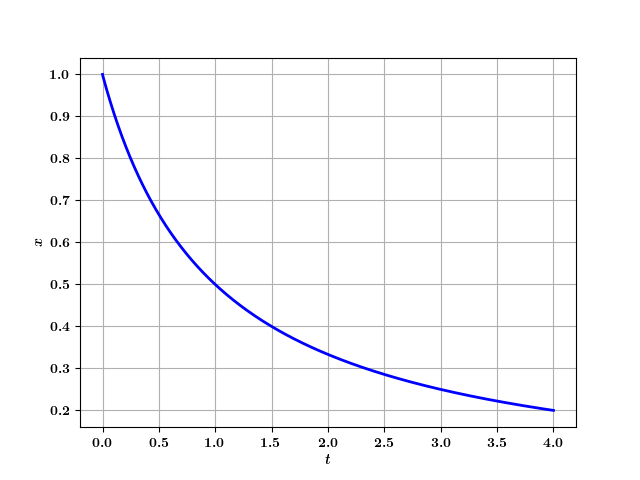

In [5]:
# -----------------------------------------------------------------
# --- Solve d x / d t = - x**2: standart method (for reference) ---
# -----------------------------------------------------------------
from scipy.integrate import RK45
mix.reload_module(mix)

oo = RK45(
    lambda t,x: -x**2, 
    t[0], 
    [x_center], t[-1], first_step=dt, max_step=dt
)

x_direct = np.zeros(Nt, dtype=float)
x_direct[0] = x_center
Nt_act = 1

oo.step()
oo.t

while mix.compare_two_strings(oo.status, "running"):
    oo.step()
    Nt_act += 1
    if Nt_act - 1 == Nt:
        print(oo.t)
    x_direct[Nt_act-1]   = float(oo.y[0])
    
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t, x_direct, color='b', linewidth = 2, linestyle='-')
plt.xlabel('$t$')
plt.ylabel("$x$")
plt.grid(True)
plt.show()

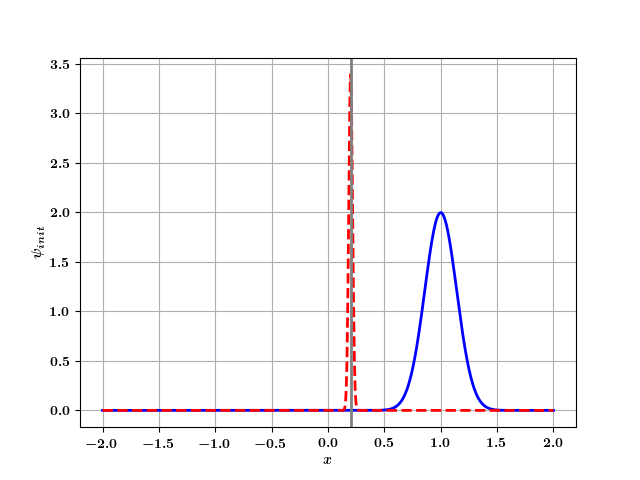

In [6]:
# ---------------------------------------------------------------------------------------------------
# --- Print psi(x) at different t ---
# ---------------------------------------------------------------------------------------------------
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, psi_tx[0,:], color='b', linewidth = 2, linestyle='-')
ax.plot(x, psi_tx[-1,:], color='r', linewidth = 2, linestyle='--')
# ax.vlines(x_direct[-1], ax.get_ylim()[0]-1, ax.get_ylim()[1]+1)
ax.axvline(x_direct[-1], ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], color = 'gray', linewidth = 2, linestyle = "-")
plt.xlabel('$x$')
plt.ylabel("$\psi_{init}$")
# ax.legend()
plt.grid(True)
plt.show()

(0.0, 1.5)

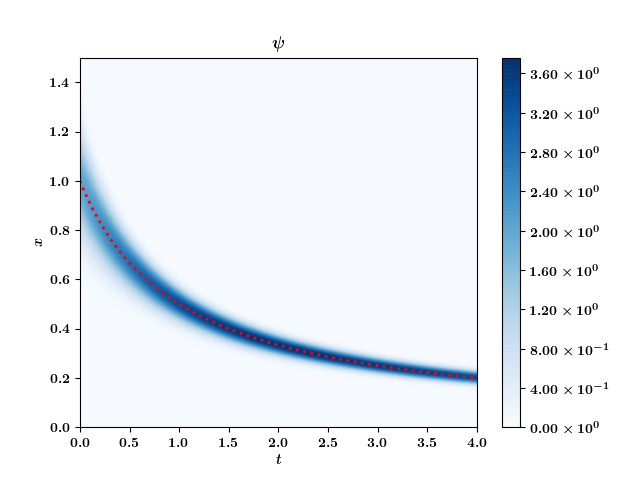

In [7]:
# ---------------------------------------------------------------------------------------------------
# --- Print psi(t,x) ---
# ---------------------------------------------------------------------------------------------------
XX, YY = np.meshgrid(t, x)

plt.close()
fig_tx = plt.figure()
ax = fig_tx.add_subplot(111)
cs = ax.contourf(XX, YY, psi_tx_transposed, levels=100, cmap=cmap_two_signs_)
fig_tx.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
ax.plot(t, x_direct, color='r', linewidth = 2, linestyle=':')
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$\psi$')
ax.set_ylim(0.0, 1.5)